# This  notebook provides the training process for the clock classifcation and clock recognition ⏹ ▶ ⏲.

In [ ]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,ResNet18_Weights
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.transforms.functional import crop
from PIL import Image, ImageOps
#some of the data preprocessing that we tried to enhance the clock classification model
#1-(addition local data that need to be cropped) #2-(train with grayscale images)
def crop_top_corner(img):
    w, h = img.size
    return crop(img, 0, 0,(h*20)/100 ,(w*40)/100)
def gray(img):
    # applying grayscale method
    gray_image = ImageOps.grayscale(img)
    return gray_image


In [ ]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Create Dataset
TRAIN_ROOT =r"C:\Users\Jawha\Desktop\football_classifcation\mix_dataset\train"
VALID_ROOT =r"C:\Users\Jawha\Desktop\football_classifcation\mix_dataset\valid"

train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
valid_ds = ImageFolder(VALID_ROOT, transform=tfm)


In [ ]:
# Length of Train and Test Datasets
LEN_TRAIN = len(train_ds)
LEN_VALID = len(valid_ds)

print(LEN_TRAIN, LEN_VALID)

# Index Mapping
print(train_ds.class_to_idx)

5782 1705
{'no': 0, 'yes': 1}


In [ ]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
valid_loader= DataLoader(valid_ds, batch_size=30, shuffle = True)

In [ ]:
# Model
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)


In [ ]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

In [ ]:
for epoch in range(3):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in valid_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_VALID
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")

100%|██████████| 193/193 [13:00<00:00,  4.05s/batch]


Epoch: 0, Time: 14.231506510575612, Loss: 8.626571798231453e-05
Train_acc: 0.9998270494638534, Test_acc: 0.967741935483871


100%|██████████| 193/193 [11:57<00:00,  3.72s/batch]


Epoch: 1, Time: 13.225586867332458, Loss: 0.00010000321344705299
Train_acc: 0.9998270494638534, Test_acc: 0.967741935483871


100%|██████████| 193/193 [12:03<00:00,  3.75s/batch]


Epoch: 2, Time: 13.294402519861857, Loss: 7.890641427366063e-05
Train_acc: 0.99948114839156, Test_acc: 0.967741935483871


In [ ]:
# Image Samples
sample_1 =r"C:\Users\Jawha\Desktop\football_classifcation\valid\no\112_c.png"
sample_2 =r"C:\Users\Jawha\Desktop\football_classifcation\valid\yes\998.png"
sample_3 =r"C:\Users\Jawha\Desktop\football_classifcation\valid\yes\4018.png"
sample_4 =r"C:\Users\Jawha\Desktop\football_classifcation\valid\no\105_c.png"
sample_list = [sample_1,sample_2,sample_3,sample_4]

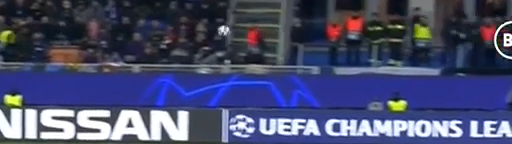

Model prediction 0, hence there is no clock


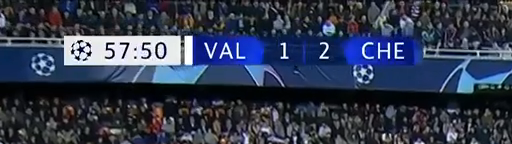

Model prediction 1, hence there is clock


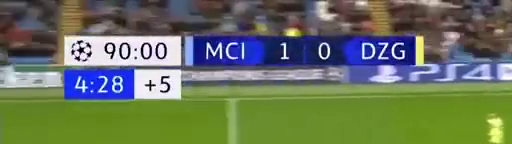

Model prediction 1, hence there is clock


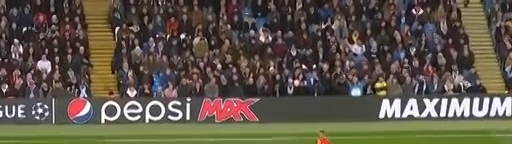

Model prediction 0, hence there is no clock


In [ ]:
# Model Performance on some image samples from the test set
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img)
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, hence there is clock")
    else:
        print(f"Model prediction {pred}, hence there is no clock")

    print("========================================================")

In [ ]:
def isTimeFormat(s):
    return bool(re.findall(r'[0-9]+:[0-9]',s))

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


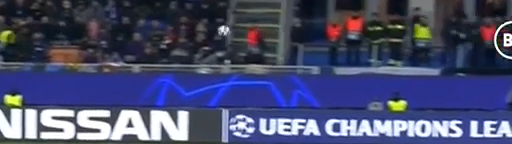

There is no clock


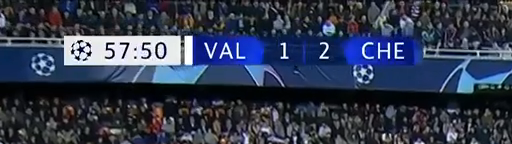

The clock is ['57:50']


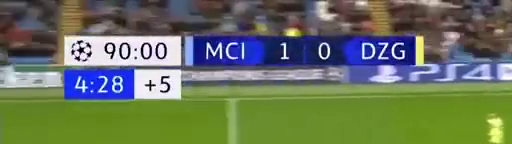

The clock is ['90:00', '4:28']


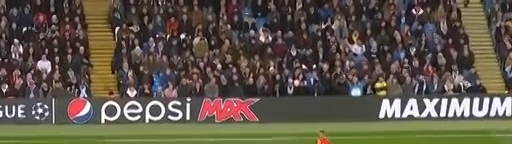

There is no clock


In [ ]:
#Clock Recognition
from PIL import Image
import numpy as np
import easyocr
import cv2
reader = easyocr.Reader(['ar','en']) # this needs to run only once to load the model into memory

for image_path in sample_list:
    img = Image.open(image_path)
    display(img)
    cv=cv2.imread(image_path)
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    clock=[]
    if pred == 1:
        #If the image has clock , extract the text using OCR
        result = reader.readtext(cv, detail = 0)
        #Extracting the time by checking the text format
        for item in result:
            if isTimeFormat(item):
                # In some conditions, we may have the time of the match and the additional minutes for the wasted time
                clock.append(item)
        print(f"The clock is {clock}")
    else:
        print("There is no clock")

    print("========================================================")
